# Clusterización de las secciones de Santander

En este cuaderno llevaremos a cabo un estudio muy sencillo de clusterización de las secciones electorales de un territorio, en este caso el municipio de Santander.

Nos serviremos de Geopandas para ver los resultados de manera gráfica. Probaremos varios métodos de clusterización, principalmente del voto en las elecciones de abril de 2019. Finalmente aplicaremos como criterio las principales variables socioeconómicas.

##Carga de Geopandas y dataset de abril 2019

Comenzamos cargando Geopandas, así como las librerías que son necesarias para hacerlo funcionar.

In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,374 kB/s)
Selecting previously unselected

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargamos el fichero shapefile con la definición geométrica de las secciones electorales en 2019.

In [ ]:
secciones = gpd.read_file('/content/drive/MyDrive/Geopandas - Data/Geopandas_A19/SECC_CE_20190101.shp')

In [ ]:
secciones.head()

,OBJECTID,CUSEC,CUMUN,CSEC,CDIS,CMUN,CPRO,CCA,CUDIS,CLAU2,NPRO,NCA,CNUT0,CNUT1,CNUT2,CNUT3,ESTADO,OBS,Shape_Leng,Shape_area,Shape_len,SUPERF_M2,NMUN,geometry
0,1,0100901001,01009,001,01,009,01,16,0100901,01009,Araba/Álava,País Vasco,ES,2,1,1,I,None,51725.353538,6.326080e+07,51725.353538,63260804,Asparrena,"MULTIPOLYGON (((556453.835 4752758.332, 556460..."
1,2,0101001002,01010,002,01,010,01,16,0101001,01010,Araba/Álava,País Vasco,ES,2,1,1,I,None,13350.774728,7.332951e+06,13350.774728,7332951,Ayala/Aiara,"POLYGON ((502035.230 4771813.197, 502048.071 4..."
2,3,0103101001,01031,001,01,031,01,16,0103101,01031,Araba/Álava,País Vasco,ES,2,1,1,I,None,87711.717051,8.041601e+07,87711.717051,80416015,Laguardia,"MULTIPOLYGON (((538984.636 4718139.608, 538985..."
3,4,0103301001,01033,001,01,033,01,16,0103301,01033,Araba/Álava,País Vasco,ES,2,1,1,I,None,12331.494377,5.950453e+06,12331.494377,5950453,Lapuebla de Labarca,"POLYGON ((537063.531 4703664.589, 536887.844 4..."
4,6,0103701001,01037,001,01,037,01,16,0103701,01037,Araba/Álava,País Vasco,ES,2,1,1,I,None,60761.315212,1.227207e+08,60761.315212,122720687,Arraia-Maeztu,"POLYGON ((551570.951 4739269.962, 551570.889 4..."


In [ ]:
secciones.shape

(36317, 24)

Hacemos un sencillo plot para ver que vamos bien.

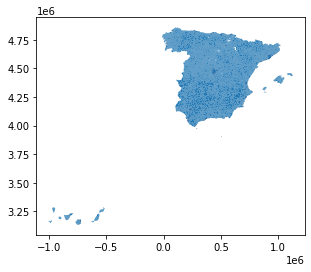

In [ ]:
secciones.plot()

In [ ]:
secciones.dtypes

OBJECTID         int64
CUSEC           object
CUMUN           object
CSEC            object
CDIS            object
CMUN            object
CPRO            object
CCA             object
CUDIS           object
CLAU2           object
NPRO            object
NCA             object
CNUT0           object
CNUT1           object
CNUT2           object
CNUT3           object
ESTADO          object
OBS             object
Shape_Leng     float64
Shape_area     float64
Shape_len      float64
SUPERF_M2        int64
NMUN            object
geometry      geometry
dtype: object

Comprobamos la proyección utilizada, siempre importante.

In [ ]:
secciones.crs

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-5.9999999999999, 35.265663028, 1.7053025658242e-13, 80.489344496333)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Podemos ver las distintas provincias de España en Geopandas

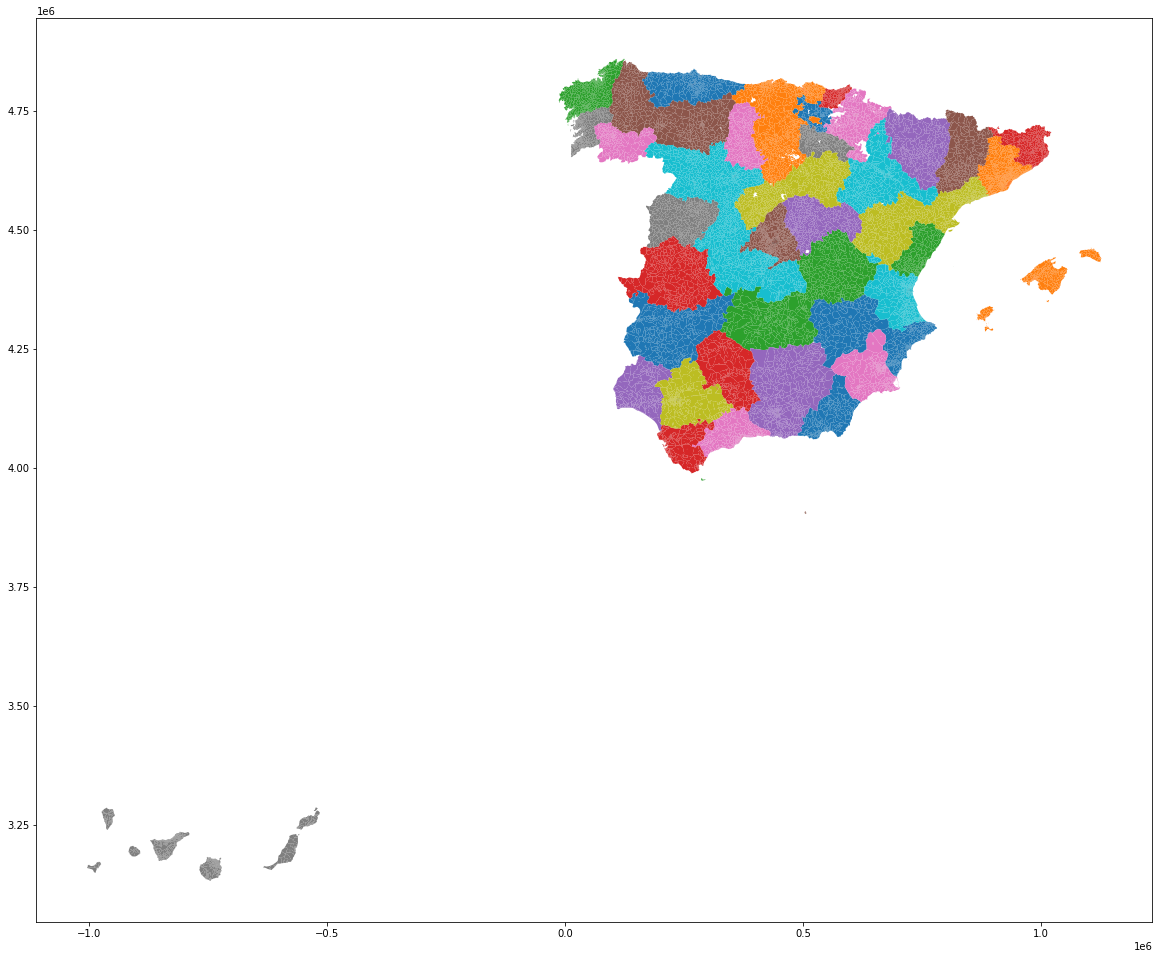

In [ ]:
secciones.plot(column = 'NPRO', figsize = (20,20))

Ahora cargamos el dataset de las secciones electorales de abril 2019.

In [ ]:
cols_str = {'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str', 'cod_sec' : 'str'}

In [ ]:
df_secciones = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/gen_A19_unif_cols_prov.txt', dtype = cols_str)

In [ ]:
df_secciones

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,022019041010400101001,01,04,04001,0400101001,Andalucía,Almería,Abla,1014,768,0.757396,5,763,9,754,149,326,131,44,0,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,73,80,89,81,94,87,91,77,72,42,67,56,19,4,0,1249,635,614,0.269816,0.590072,0.140112,291.0,0.243986,0.232986,143.0,0.419580,0.559441,0.329493,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 149, 'PSOE': 326, 'Cs': 131, 'UP': 44, ...","[('PSOE', 326), ('PP', 149), ('Cs', 131), ('VO..."
1,022019041010400201001,01,04,04002,0400201001,Andalucía,Almería,Abrucena,1039,798,0.768046,6,792,7,785,127,380,91,60,0,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,...,60,75,70,70,108,101,99,86,61,64,61,46,14,2,1,1202,637,565,0.278702,0.609817,0.111481,323.0,0.238390,0.268719,158.0,0.367089,0.601266,0.328482,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 127, 'PSOE': 380, 'Cs': 91, 'UP': 60, '...","[('PSOE', 380), ('PP', 127), ('VOX', 113), ('C..."
2,022019041010400301001,01,04,04003,0400301001,Andalucía,Almería,Adra,671,519,0.773472,4,515,1,514,162,131,68,44,0,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,...,54,54,54,61,82,75,67,48,37,40,26,15,3,1,0,892,435,457,0.190583,0.643498,0.165919,7571.0,0.393871,8.487668,3036.0,0.399868,0.459157,0.286226,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 162, 'PSOE': 131, 'Cs': 68, 'UP': 44, '...","[('PP', 162), ('PSOE', 131), ('VOX', 103), ('C..."
3,022019041010400301002,01,04,04003,0400301002,Andalucía,Almería,Adra,1282,954,0.744150,13,941,7,934,239,241,166,62,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,...,108,158,162,150,140,119,103,67,49,37,30,14,7,1,0,1752,865,887,0.117009,0.647260,0.235731,7571.0,0.393871,4.321347,3036.0,0.399868,0.459157,0.286226,8599.0,7941.0,25677.0,23400.0,5381.0,4837.0,1815.0,1724.0,343.0,464.0,"{'PP': 239, 'PSOE': 241, 'Cs': 166, 'UP': 62, ...","[('PSOE', 241), ('PP', 239), ('VOX', 218), ('C..."
4,022019041010400301003,01,04,04003,0400301003,Andalucía,Almería,Adra,1535,1087,0.708143,20,1067,6,1061,274,252,170,67,0,282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,189,178,215,227,164,110,96,61,58,41,40,27,4,4,0,2240,1094,1146,0.104911,0.647768,0.247321,7571.0,0.393871,3.379911,3036.0,0.399868,0.459157,0.286226,8076.0,7150.0,22051.0,19687.0,5224.0,4044.0,1170.0,1198.0,416.0,476.0,"{'PP': 274, 'PSOE': 252, 'Cs': 170, 'UP': 67, ...","[('VOX', 282), ('PP', 274), ('PSOE', 252), ('C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36312,022019041195200108011,19,52,52001,5200108011,Melilla,Melilla,Melilla,1605,1118,0.696573,9,1109,4,1105,250,194,168,38,0,167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,288,...,181,185,171,164,165,180,155,97,38,34,19,16,4,3,0,2480,1244,1236,0.085081,0.623387,0.291532,24290.0,0.193413,9.794355,11827.0,0.381331,0.398326,0.327464,16433.0,15847.0,66352.0,62632.0,11378.0,11119.0,1508.0,1274.0,167.0,166.0,"{'PP': 250, 'PSOE': 194, 'Cs': 168, 'UP': 38, ...

In [ ]:
df_secciones.dtypes

Sección                  object
cod_ccaa                 object
cod_prov                 object
cod_mun                  object
cod_sec                  object
                         ...   
Renta Pensiones 2015    float64
Renta Desempleo 2018    float64
Renta Desempleo 2015    float64
dict_res                 object
dict_res_ord             object
Length: 97, dtype: object

Debemos hacer un merge de los dataset de shapefile y las secciones electorales. Unificamos los nombres de las columnas comunes.

In [ ]:
df_secciones = df_secciones.rename(columns = {'cod_sec': 'CUSEC'})

In [ ]:
df_secciones.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'CUSEC', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayore

In [ ]:
secciones.columns

Index(['OBJECTID', 'CUSEC', 'CUMUN', 'CSEC', 'CDIS', 'CMUN', 'CPRO', 'CCA',
       'CUDIS', 'CLAU2', 'NPRO', 'NCA', 'CNUT0', 'CNUT1', 'CNUT2', 'CNUT3',
       'ESTADO', 'OBS', 'Shape_Leng', 'Shape_area', 'Shape_len', 'SUPERF_M2',
       'NMUN', 'geometry'],
      dtype='object')

##Merge de los datasets y representación con Geopandas

Hacemos el merge según el nombre de la sección.

In [ ]:
secciones = pd.merge(secciones, df_secciones, how="left", on=['CUSEC'])

In [ ]:
secciones

,OBJECTID,CUSEC,CUMUN,CSEC,CDIS,CMUN,CPRO,CCA,CUDIS,CLAU2,NPRO,NCA,CNUT0,CNUT1,CNUT2,CNUT3,ESTADO,OBS,Shape_Leng,Shape_area,Shape_len,SUPERF_M2,NMUN,geometry,Sección,cod_ccaa,cod_prov,cod_mun,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,...,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,1,0100901001,01009,001,01,009,01,16,0100901,01009,Araba/Álava,País Vasco,ES,2,1,1,I,None,51725.353538,6.326080e+07,51725.353538,63260804,Asparrena,"MULTIPOLYGON (((556453.835 4752758.332, 556460...",022019041140100901001,14,01,01009,Murcia,Álava,Asparrena,1265,920,0.727273,6,914,6,908,28,113,...,80,91,126,127,151,166,118,94,68,43,53,39,19,5,0,1614,826,788,0.198885,0.617100,0.184015,1117.0,0.085049,0.692069,205.0,0.502439,0.526829,0.155068,13993.0,13218.0,31465.0,30412.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'PP': 28, 'PSOE': 113, 'Cs': 7, 'UP': 163, 'I...","[('Bildu', 325), ('PNV', 244), ('UP', 163), ('..."
1,2,0101001002,01010,002,01,010,01,16,0101001,01010,Araba/Álava,País Vasco,ES,2,1,1,I,None,13350.774728,7.332951e+06,13350.774728,7332951,Ayala/Aiara,"POLYGON ((502035.230 4771813.197, 502048.071 4...",022019041140101001002,14,01,01010,Murcia,Álava,Ayala / Aiara,895,687,0.767598,7,680,8,672,32,91,...,46,91,207,180,106,59,30,27,27,23,15,11,6,0,0,1271,644,627,0.085759,0.615264,0.298977,1112.0,0.226619,0.874902,275.0,0.407273,0.501818,0.198270,13827.0,13317.0,37181.0,36309.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'PP': 32, 'PSOE': 91, 'Cs': 13, 'UP': 141, 'I...","[('PNV', 245), ('UP', 141), ('Bildu', 132), ('..."
2,3,0103101001,01031,001,01,031,01,16,0103101,01031,Araba/Álava,País Vasco,ES,2,1,1,I,None,87711.717051,8.041601e+07,87711.717051,80416015,Laguardia,"MULTIPOLYGON (((538984.636 4718139.608, 538985...",022019041140103101001,14,01,01031,Murcia,Álava,Laguardia,1163,948,0.815133,20,928,6,922,224,146,...,100,84,104,130,125,145,102,97,82,38,45,43,10,4,0,1494,767,727,0.213521,0.617805,0.168675,1948.0,0.122690,1.303882,145.0,0.379310,0.496552,0.069279,13470.0,13146.0,30543.0,29985.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'PP': 224, 'PSOE': 146, 'Cs': 35, 'UP': 117, ...","[('PP', 224), ('PNV', 212), ('PSOE', 146), ('B..."
3,4,0103301001,01033,001,01,033,01,16,0103301,01033,Araba/Álava,País Vasco,ES,2,1,1,I,None,12331.494377,5.950453e+06,12331.494377,5950453,Lapuebla de Labarca,"POLYGON ((537063.531 4703664.589, 536887.844 4...",022019041140103301001,14,01,01033,Murcia,Álava,Lapuebla de Labarca,656,533,0.812500,8,525,1,524,78,99,...,37,69,81,52,79,49,73,44,31,27,43,16,10,3,1,865,439,426,0.202312,0.595376,0.202312,453.0,0.284768,0.523699,113.0,0.460177,0.415929,0.199647,11471.0,10861.0,27363.0,26163.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'PP': 78, 'PSOE': 99, 'Cs': 19, 'UP': 57, 'IU...","[('PNV', 218), ('PSOE', 99), ('PP', 78), ('UP'..."
4,6,0103701001,01037,001,01,037,01,16,0103701,01037,Araba/Álava,País Vasco,ES,2,1,1,I,None,60761.315212,1.227207e+08,60761.315212,122720687,Arraia-Maeztu,"POLYGON ((551570.951 4739269.962, 551570.889 4...",022019041140103701001,14,01,01037,Murcia,Álava,Arraia-Maeztu,585,426,0.728205,1,425,1,424,56,40,...,42,48,68,72,53,56,49,39,51,28,20,28,11,0,1,726,403,323,0.245179,0.582645,0.172176,165.0,0.478788,0.227273,53.0,0.471698,0.490566,0.243119,15072.0,15193.0,33158.0,33591.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'PP': 56, 'PSOE': 40, 'Cs': 6, 'UP': 55, 'IU'...","[('PNV', 163), ('Bildu', 94), ('PP', 56), ('UP..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Una variable importante es el partido político, por lo que preparamos un mapa para poder representarlo por secciones.

In [ ]:
color_map = {'BNG': 'green',
 'CC': '#C0CB2F',
 'Compromis': '#C29518',
 'Cs': 'orange',
 'ERC': 'yellow',
 'GBai': '#C93011',
 'JxC': '#3201AB',
 'Otros': 'cyan',
 'PACMA': 'pink',
 'PNV': '#8ED8A5',
 'PP': '#1604FA',
 'PRC': '#1E8E41',
 'PSOE': 'red',
 'UP': 'purple',
 'VOX': 'lightgreen'}

Ahora seleccionamos las seccines del municipio de Santander, que representamos según el partido ganador en abril de 2019, casi en todos los casos PP o PSOE.

In [ ]:
secciones_SAN = secciones.loc[secciones['Municipio'] == 'Santander']

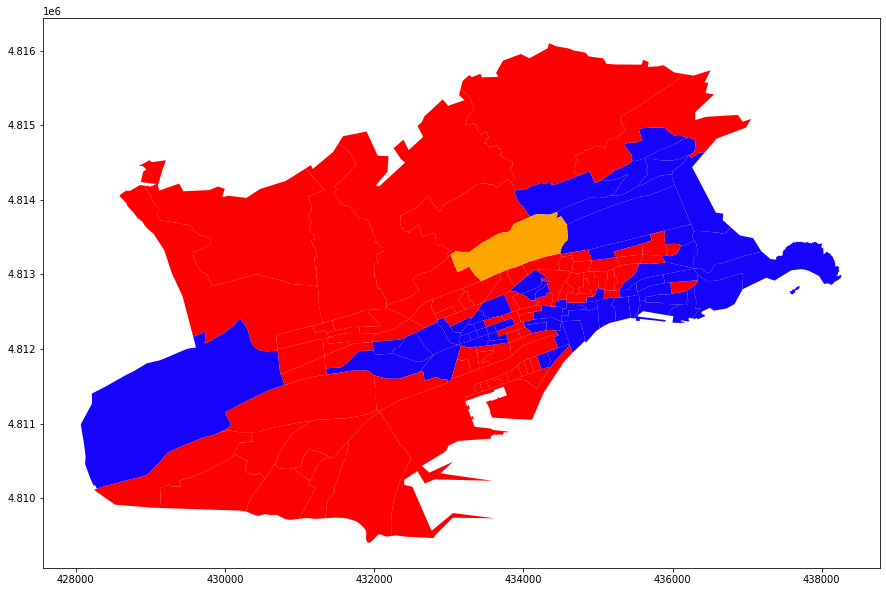

In [ ]:
secciones_SAN.plot(figsize = (15,15), color = secciones_SAN['Ganador'].map(color_map))

La segunda posición estuvo más repartida, entre muchos partidos.

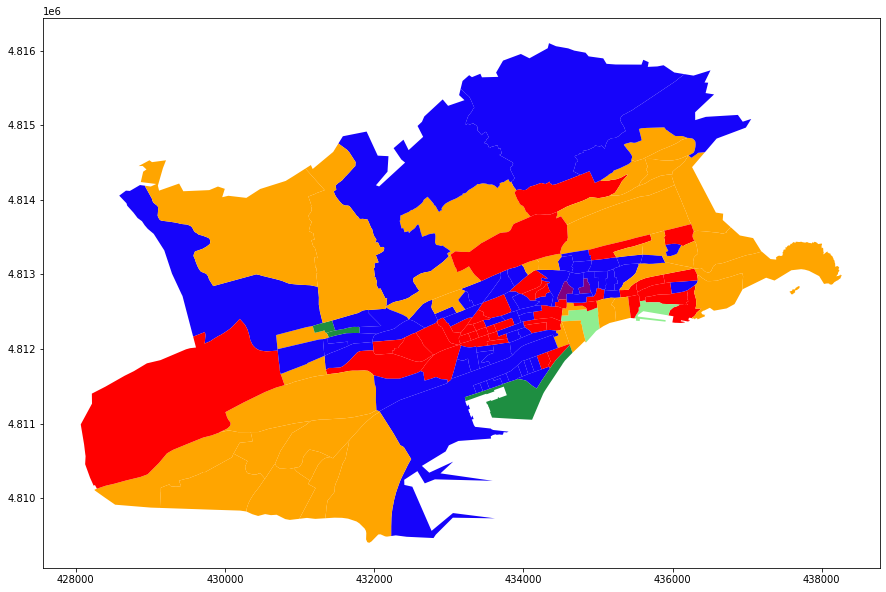

In [ ]:
secciones_SAN.plot(figsize = (15,15), color = secciones_SAN['Segundo'].map(color_map))

In [ ]:
secciones_SAN.columns

Index(['OBJECTID', 'CUSEC', 'CUMUN', 'CSEC', 'CDIS', 'CMUN', 'CPRO', 'CCA',
       'CUDIS', 'CLAU2',
       ...
       'Renta hogar 2017', 'Renta hogar 2015', 'Renta Salarios 2018',
       'Renta Salarios 2015', 'Renta Pensiones 2018', 'Renta Pensiones 2015',
       'Renta Desempleo 2018', 'Renta Desempleo 2015', 'dict_res',
       'dict_res_ord'],
      dtype='object', length=120)

##Clusterización por voto en abril 2019

Ahora pasamos a la clusterización. Vamos a hacerlo según el voto de las secciones. Para ello seleccionamos las columnas relevantes: censo, participación y porcentaje de voto a los principales partidos.

In [ ]:
cols_utiles_clust = ['Censo_Esc', 'Participación', '% PP', '% PSOE', '% UP', '% Vox', '% Cs']

In [ ]:
secciones_SAN_clust = secciones_SAN[cols_utiles_clust]

In [ ]:
secciones_SAN_clust

,Censo_Esc,Participación,% PP,% PSOE,% UP,% Vox,% Cs
25032,740,0.724324,0.285714,0.255639,0.082707,0.112782,0.157895
25033,776,0.824742,0.388715,0.119122,0.050157,0.192790,0.188088
25034,589,0.740238,0.249423,0.200924,0.115473,0.122402,0.173210
25040,623,0.820225,0.339882,0.186640,0.074656,0.111984,0.202358
25041,850,0.755294,0.191153,0.246445,0.132701,0.118483,0.167457
...,...,...,...,...,...,...,...
25228,1093,0.741995,0.200498,0.229141,0.073474,0.130760,0.181818
25289,1952,0.805840,0.207294,0.255278,0.099808,0.106206,0.206654
36115,831,0.667870,0.180000,0.323636,0.114545,0.114545,0.121818
36116,848,0.784198,0.364188,0.213961,0.051593,0.133536,0.165402


In [ ]:
secciones_SAN_clust.describe()

,Censo_Esc,Participación,% PP,% PSOE,% UP,% Vox,% Cs
count,147.000000,147.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,932.238095,0.756788,0.239901,0.249808,0.096118,0.119909,0.163598
std,300.584871,0.077783,0.070831,0.058806,0.030030,0.031931,0.031216
min,475.000000,0.000000,0.112583,0.065903,0.019417,0.045213,0.105856
25%,725.500000,0.726493,0.184818,0.217049,0.075040,0.099682,0.140177
50%,864.000000,0.761755,0.227888,0.253900,0.094825,0.114699,0.157624
75%,1103.000000,0.798719,0.282441,0.289542,0.114443,0.136249,0.184463
max,1952.000000,0.852223,0.483311,0.360294,0.188725,0.201780,0.260654


Es necesario rellenar los registros de nan, de los que hay uno.

In [ ]:
FillNA_num_mean = secciones_SAN_clust.columns

In [ ]:
for item in FillNA_num_mean:
        
    secciones_SAN_clust[item].fillna(secciones_SAN_clust[item].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
secciones_SAN_clust.describe()

,Censo_Esc,Participación,% PP,% PSOE,% UP,% Vox,% Cs
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,932.238095,0.756788,0.239901,0.249808,0.096118,0.119909,0.163598
std,300.584871,0.077783,0.070588,0.058604,0.029927,0.031821,0.031109
min,475.000000,0.000000,0.112583,0.065903,0.019417,0.045213,0.105856
25%,725.500000,0.726493,0.184922,0.217920,0.075423,0.099788,0.140354
50%,864.000000,0.761755,0.229798,0.253414,0.095137,0.114853,0.157895
75%,1103.000000,0.798719,0.282388,0.289340,0.114341,0.136135,0.183851
max,1952.000000,0.852223,0.483311,0.360294,0.188725,0.201780,0.260654


Para clusterizar conviene el normalizar, para lo que usamos los métodos para ello que proporcional SKlearn.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
cs = MinMaxScaler()

In [ ]:
secciones_SAN_clust_norm = cs.fit_transform(secciones_SAN_clust)

In [ ]:
secciones_SAN_clust_norm

array([[0.17941774, 0.84992355, 0.46700374, ..., 0.37381155, 0.43156546,
        0.33617227],
       [0.20379147, 0.96775415, 0.74483645, ..., 0.18155823, 0.94257788,
        0.53121992],
       [0.07718348, 0.86859632, 0.36911089, ..., 0.56734447, 0.49300786,
        0.43511023],
       ...,
       [0.24102911, 0.78367998, 0.18185075, ..., 0.56186341, 0.44282895,
        0.10311696],
       [0.25253893, 0.92017956, 0.67867865, ..., 0.19004326, 0.56411969,
        0.38467015],
       [0.00270819, 0.84269365, 0.3036278 , ..., 0.48976834, 0.53294665,
        0.14728276]])

Comenzamos como primer método el KMeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_SAN = KMeans(n_clusters=5, random_state=0).fit(secciones_SAN_clust_norm)

In [ ]:
kmeans_SAN.labels_

array([0, 4, 2, 0, 2, 3, 0, 0, 0, 1, 2, 2, 3, 0, 4, 3, 2, 0, 3, 2, 2, 2,
       4, 2, 3, 2, 4, 3, 2, 0, 2, 2, 3, 0, 4, 3, 3, 3, 3, 0, 0, 0, 2, 0,
       4, 3, 2, 2, 0, 2, 3, 0, 0, 3, 4, 4, 4, 3, 3, 3, 0, 3, 3, 3, 2, 0,
       0, 0, 3, 0, 3, 3, 2, 1, 0, 2, 0, 0, 2, 3, 0, 4, 3, 2, 3, 1, 3, 3,
       3, 2, 1, 4, 4, 3, 1, 0, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 0, 3, 3, 1,
       1, 0, 1, 4, 3, 3, 2, 3, 3, 0, 1, 0, 1, 3, 1, 1, 3, 1, 3, 3, 1, 4,
       1, 0, 4, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 2], dtype=int32)

Incluimos los labels de la clusterización de KMeans en el dataset resultado del merge.

In [ ]:
secciones_SAN['Cluster_KMeans'] = kmeans_SAN.labels_

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1345: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Vemos un pequeño análisis de los labels

In [ ]:
secciones_SAN['Cluster_KMeans'].describe()

count    147.000000
mean       1.938776
std        1.340744
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Cluster_KMeans, dtype: float64

In [ ]:
secciones_SAN['Cluster_KMeans'].value_counts()

3    50
0    32
2    25
1    25
4    15
Name: Cluster_KMeans, dtype: int64

Vamos a representarlos en el mapa, para lo que elegimos colores según los lables

In [ ]:
color_map_Kmeans = { 0 : 'blue',
                     1 : 'red',
                     2 : 'green',
                     3 : 'brown',
                     4 : 'purple'}

Y lo pintamos en el mapa. Hay una evidente distribución geográfica. En morado (4) está el área del Sardinero, que suele votar a la derecha. Zonas en rojo (1) y marrón (3) tienen un voto más progresista.

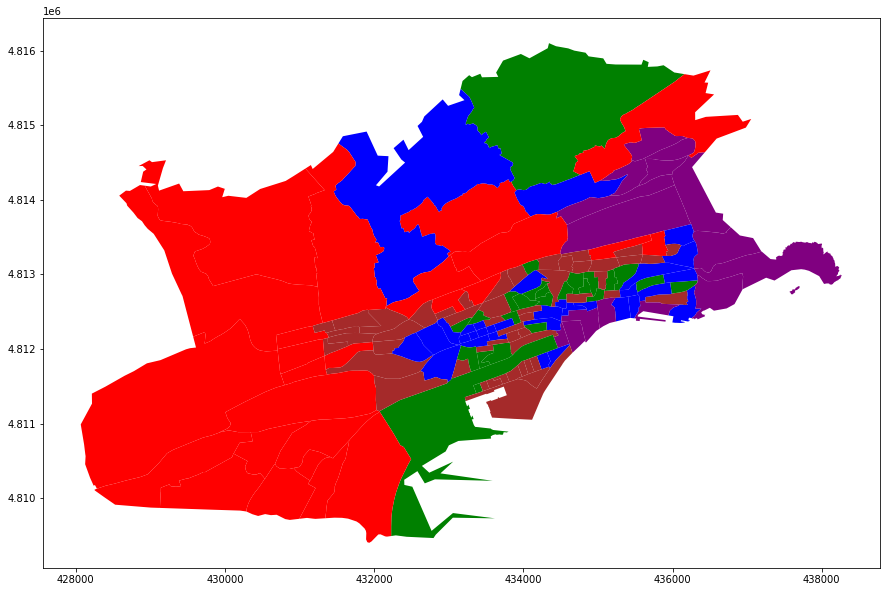

In [ ]:
#fig, ax = plt.subplots(1, 1)

secciones_SAN.plot(figsize = (15,15), color = secciones_SAN['Cluster_KMeans'].map(color_map_Kmeans))

Podemos obtener el porcentaje de voto medio por partidos en cada label del Kmeans, y se comprueban las tendencias que hemos descrito antes.

In [ ]:
grouped_SAN = secciones_SAN[['% PP', '% PSOE', '% UP', '% Vox', '% Cs', 'Cluster_KMeans']].groupby(by=['Cluster_KMeans'], dropna=True).mean()

In [ ]:
grouped_SAN

,% PP,% PSOE,% UP,% Vox,% Cs
Cluster_KMeans,,,,,
0,0.299694,0.213821,0.075508,0.136540,0.161539
1,0.176121,0.251375,0.108475,0.121639,0.196124
2,0.213816,0.259883,0.134505,0.108352,0.145428
3,0.210272,0.301409,0.099374,0.095635,0.144431
4,0.359143,0.135845,0.047216,0.180946,0.206744


Hemos intentado clusterizar mediante DBSCAM, pero no hemos tenido éxito, pues seleccionaba un cluster (0) o simplemente ninguno (-1).

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBSCAN_SAN = DBSCAN(eps=0.29, min_samples=5).fit(secciones_SAN_clust_norm)

In [ ]:
DBSCAN_SAN.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,
        0, -1,  0,  0, -1,  1,  0, -1,  0,  0,  0])

Probamos con el AgglomerativeClustering, y sí parece que obtenemos algo coherente.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
aglometative_SAN = AgglomerativeClustering(n_clusters = 5).fit(secciones_SAN_clust_norm)

In [ ]:
aglometative_SAN.labels_

array([0, 3, 2, 2, 0, 0, 2, 2, 3, 4, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 1, 3, 0, 0, 0, 0, 2, 2, 2, 2, 3,
       3, 0, 0, 0, 2, 0, 0, 2, 2, 0, 3, 3, 3, 0, 4, 0, 2, 0, 0, 0, 0, 2,
       2, 1, 0, 0, 0, 0, 2, 4, 2, 2, 2, 2, 0, 0, 1, 3, 0, 0, 0, 4, 0, 4,
       0, 0, 1, 3, 3, 0, 1, 2, 1, 0, 1, 1, 0, 1, 4, 4, 0, 0, 0, 0, 4, 4,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 1, 1, 1, 0, 1, 1, 0, 4, 0, 0, 4, 1,
       4, 2, 1, 0, 0, 0, 0, 0, 1, 4, 1, 1, 0, 2, 0])

In [ ]:
secciones_SAN['Cluster_aglomerative'] = aglometative_SAN.labels_

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1345: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



En este caso, uno de los labels (0) predomina sobre el resto.

In [ ]:
secciones_SAN['Cluster_aglomerative'].value_counts()

0    71
2    25
1    23
3    15
4    13
Name: Cluster_aglomerative, dtype: int64

In [ ]:
color_map_aglomerative = { 0 : 'blue',
                     1 : 'red',
                     2 : 'green',
                     3 : 'brown',
                     4 : 'purple'}

Lo cierto es que, de nuevo, el Sardi vuelve a destacar, en este caso en marrón (3), mientras que el centro de la ciudad es azul (0).

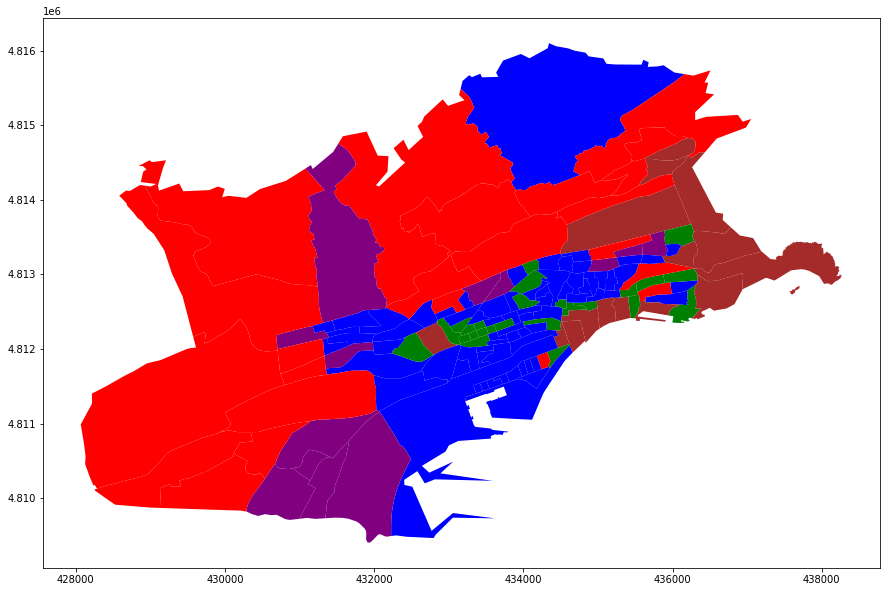

In [ ]:
secciones_SAN.plot(figsize = (15,15), color = secciones_SAN['Cluster_aglomerative'].map(color_map_aglomerative))

In [ ]:
secciones_SAN['Cluster_aglomerative'].describe()

count    147.000000
mean       1.156463
std        1.358387
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: Cluster_aglomerative, dtype: float64

Si analizamos el voto por labels, comprobamos que el Sardinero (marrón, 3) va por libre, mientras que en el centro (azul, 0) gana el PSOE, pero de forma menos contundente que en el (morado, 4), de las afueras, que tiende a votar más a la izquierda.

In [ ]:
grouped_SAN_aglo = secciones_SAN[['% PP', '% PSOE', '% UP', '% Vox', '% Cs', 'Cluster_aglomerative']].groupby(by=['Cluster_aglomerative'], dropna=True).mean()

In [ ]:
grouped_SAN_aglo

,% PP,% PSOE,% UP,% Vox,% Cs
Cluster_aglomerative,,,,,
0,0.214404,0.288612,0.109445,0.100710,0.142198
1,0.220919,0.219831,0.085578,0.137898,0.208831
2,0.293601,0.215424,0.084045,0.132493,0.158243
3,0.366543,0.139856,0.050054,0.175010,0.193298
4,0.161383,0.286888,0.119373,0.103680,0.174833


## Ejemplo de dendrograma

Hemos hecho un pequeño experimento intentando calcular un dendrograma con el voto de los santanderinos, aunque hemos de reconocer que no sabemos muy bien sacarle el partido necesario; este procedimiento parece ser más sencillo en R que en Python.

In [ ]:
from scipy.cluster.hierarchy import dendrogram

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [ ]:
aglometative_SAN = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(secciones_SAN_clust_norm)

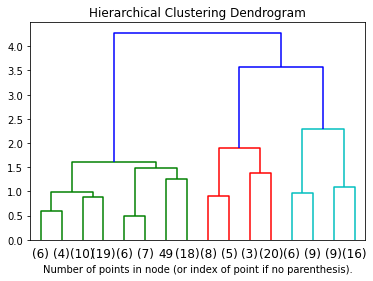

In [ ]:

figsize = (20,20)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(aglometative_SAN, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
aglometative_SAN.labels_

array([119, 130, 105, 120,  80,  88, 100, 102, 126, 121,  89, 125, 101,
       140,  81, 137, 117, 116,  98,  73,  99,  96, 122,  77, 108, 106,
       145, 143,  50, 103,  84, 107, 127, 110, 118, 139,  69, 146, 109,
        82, 138, 134, 144,  93,  71, 141,  90,  62,  52,  74,  92,  59,
        86, 112,  97,  58,  95,  75, 142,  72, 131,  49, 124,  48,  47,
        76, 135, 115, 136, 128,  57,  53, 123,  36, 129,  54,  85,  37,
        63,  24,  78,  38,  83,  23,  67,  64, 132, 114,  70, 133,  65,
        68,  61,  35,  30,  60,  94,  17,  29,  46,  34,  14, 104,  18,
        51,  79,  11,  66,  42,  41,  31,  32, 113,  44,  40,  26,   8,
        20,  28, 111,  39,  56,  55,  19,  27,  25,   9,  91,  87,  33,
        43,  21,  45,  13,  12,  15,   5,  16,  22,   7,   3,   6,  10,
         4,   1,   2,   0])

## Clusterización por datos sociales

Por último vamos a clusterizar las secciones de Santander, según una serie de columnas sociales que se muestran a continuación, son los rangos de edades y las rentas.

In [ ]:
cols_sociales = ['% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Renta persona 2017',
        'Renta hogar 2017', 
       'Renta Salarios 2018',  'Renta Pensiones 2018',
        'Renta Desempleo 2018']

In [ ]:
cols_sociales

['% mayores 65 años',
 '% 20-64 años',
 '% menores 19 años',
 'Renta persona 2017',
 'Renta hogar 2017',
 'Renta Salarios 2018',
 'Renta Pensiones 2018',
 'Renta Desempleo 2018']

De nuevo, debemos rellenar los espacios en nan.

In [ ]:
secciones_SAN_clust_soc = secciones_SAN[cols_sociales]

In [ ]:
FillNA_num_mean = secciones_SAN_clust_soc.columns

In [ ]:
for item in FillNA_num_mean:
        
    secciones_SAN_clust_soc[item].fillna(secciones_SAN_clust_soc[item].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
secciones_SAN_clust_soc.describe()

,% mayores 65 años,% 20-64 años,% menores 19 años,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,0.258892,0.586799,0.154309,13297.775510,32071.340136,8650.959184,4722.210884,213.414966
std,0.065278,0.045394,0.034010,3457.844538,8714.745590,2417.541128,1570.360875,45.601136
min,0.062385,0.478780,0.089539,8299.000000,19684.000000,4650.000000,1218.000000,110.000000
25%,0.216948,0.556095,0.132276,10841.500000,26116.000000,6996.500000,3783.500000,186.500000
50%,0.264747,0.590000,0.148191,12492.000000,30207.000000,8269.000000,4604.000000,212.000000
75%,0.301552,0.619142,0.164265,14783.500000,34611.000000,9751.500000,5449.000000,242.500000
max,0.377389,0.700910,0.305970,25242.000000,66720.000000,15868.000000,8302.000000,344.000000


Y normalizar.

Ahora aplicamos el KMeans, a ver qué encontramos:

In [ ]:
secciones_SAN_clust_soc_norm = cs.fit_transform(secciones_SAN_clust_soc)

In [ ]:
kmeans_SAN_soc = KMeans(n_clusters=5, random_state=0).fit(secciones_SAN_clust_soc_norm)

In [ ]:
kmeans_SAN_soc.labels_

array([0, 3, 0, 1, 0, 0, 0, 4, 3, 0, 0, 0, 0, 4, 3, 0, 0, 4, 4, 2, 2, 0,
       3, 4, 0, 2, 3, 0, 0, 4, 0, 0, 0, 4, 3, 0, 0, 0, 0, 4, 3, 4, 0, 1,
       3, 0, 0, 0, 4, 0, 0, 4, 4, 0, 3, 3, 3, 0, 0, 0, 4, 0, 0, 4, 0, 0,
       4, 4, 0, 4, 0, 0, 0, 2, 4, 0, 4, 4, 4, 0, 3, 3, 0, 0, 4, 0, 0, 4,
       0, 0, 0, 1, 1, 0, 1, 3, 2, 0, 2, 2, 2, 1, 2, 0, 0, 0, 4, 4, 0, 0,
       2, 1, 2, 1, 0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 1,
       2, 1, 1, 0, 0, 4, 0, 0, 2, 2, 0, 2, 0, 4, 4], dtype=int32)

In [ ]:
secciones_SAN['Cluster_KMeans_soc'] = kmeans_SAN_soc.labels_

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1345: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Socialmente parece que hay un label (0), que predomina, con la mitad de las secciones.

In [ ]:
secciones_SAN['Cluster_KMeans_soc'].value_counts()

0    73
4    28
2    18
3    15
1    13
Name: Cluster_KMeans_soc, dtype: int64

In [ ]:
color_map_KMeans_soc = { 0 : 'blue',
                     1 : 'red',
                     2 : 'green',
                     3 : 'brown',
                     4 : 'purple'}

Aunque curiosamente lo que vemos es que esta clusterización de parece bastante a la dada por Agglomerative para el voto. El Sardinero tiene un label para él solo (marrón, 3), mientras que el centro y la zona del puerto recoge el label mayoritario (azul, 0).

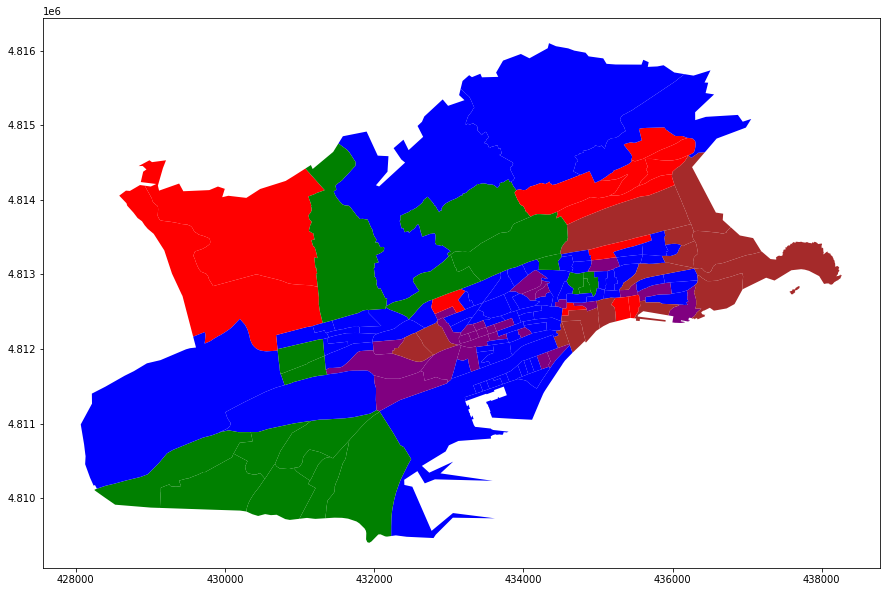

In [ ]:
secciones_SAN.plot(figsize = (15,15), color = secciones_SAN['Cluster_KMeans_soc'].map(color_map_KMeans_soc))

In [ ]:
grouped_SAN_aglo = secciones_SAN[['% PP', '% PSOE', '% UP', '% Vox', '% Cs', 'Cluster_KMeans_soc']].groupby(by=['Cluster_KMeans_soc'], dropna=True).mean()

In [ ]:
grouped_SAN_aglo

,% PP,% PSOE,% UP,% Vox,% Cs
Cluster_KMeans_soc,,,,,
0,0.209944,0.283061,0.107945,0.104524,0.149100
1,0.266755,0.194947,0.072260,0.151294,0.213566
2,0.162563,0.262773,0.122106,0.120638,0.185097
3,0.364339,0.151304,0.051447,0.171144,0.182256
4,0.287518,0.234205,0.084007,0.116981,0.153864


Vemos que la clusterización por cuestiones sociales, en cierto modo la es también por voto, ya que se nota el Sardinero con un voto muy conservador, y el label 0, el mayoritario, donde gana el PSOE. Ello indicaría, como es lógico, que las condiciones económicas y sociales son importantes para predecir el voto.